In [1]:
from are import build_steady_state_model, build_model
from parameters import are_parameters, F_to_K
from symengine import Function, Symbol 
from sympy import symbols, Eq, linsolve
import numpy as np 
import pandas as pd
from scipy.interpolate import interp1d, CubicSpline

In [2]:
# plotting style 
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "monospace"

# Set a professional color scheme
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 
          'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

tls = 22
# Function to update the style of each axis
def update_axis_style(ax, title = '', x_label='', y_label='', x_ticks=True, y_scale='linear'):
    ax.set_title(title,fontsize=tls)
    ax.set_xlabel(x_label,fontsize=tls)
    ax.set_ylabel(y_label,fontsize=tls)
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    ax.tick_params(axis='x', which='both', bottom=x_ticks, top=False, labelbottom=x_ticks,labelsize=tls)
    ax.tick_params(axis='y', which='both', left=True, right=False, labelleft=True,labelsize=tls)
    ax.set_yscale(y_scale)

lw = 3

In this notebook, we use the dynamic model of the ARE to simulate the reactivity insertion experiment described in ORNL-1845 (experiment H-8). We examine the results for different values of the thermal reactivity feedback coefficients of the fuel, moderator, and coolant. 

First, we unpack some ORNL data for comparison

In [3]:
# unpack ORNL data 
df_power_reversed = pd.read_csv("./data/insertion.csv",header=None)
df_inlet_reversed = pd.read_csv("./data/fuel_inlet_temp.csv",header=None)
df_outlet_reversed = pd.read_csv("./data/fuel_outlet_temp.csv",header=None)
df_power = df_power_reversed.iloc[::-1] 
df_inlet = df_inlet_reversed.iloc[::-1]
df_outlet = df_outlet_reversed.iloc[::-1]
df_power = df_power.reset_index(drop=True)
df_inlet = df_inlet.reset_index(drop=True)
df_outlet = df_outlet.reset_index(drop=True)
df_inlet[1] = [F_to_K(t) for t in df_inlet[1]]
df_outlet[1] = [F_to_K(t) for t in df_outlet[1]]


# adjust to reported initial values (graphical interpretaion correction)
dp = df_power[1][0]-2.34
df_power[1] = [p-dp for p in df_power[1]]

dt_fin = df_inlet[1][0]-F_to_K(1217)
df_inlet[1] = [tf-dt_fin for tf in df_inlet[1]]

dt_fout = df_outlet[1][0]-F_to_K(1573)
df_outlet[1] = [tf-dt_fout for tf in df_outlet[1]]

# avg temp
ornl_diff = [df_outlet[1][i]-df_inlet[1][i] for i in range(len(df_inlet))]
ornl_avg = sum(ornl_diff)/len(ornl_diff)

from scipy.interpolate import interp1d

dT_fuel_correction = pd.read_csv('./data/dT_fuel_correction.csv',header=None, delimiter = ';', decimal = ',')
dT_fuel_correction[0] *= 5/9  # convert from F to C
dT_fuel_correction[1] *= 5/9  # convert from F to C
dT_fuel_correction_interp = np.polyfit(dT_fuel_correction[1], dT_fuel_correction[0], 3)

df_inlet_correction = pd.read_csv('./data/inlet_correction.csv',header=None, delimiter = ';', decimal = ',')
df_inlet_correction[0] = [F_to_K(t) for t in df_inlet_correction[0]]
df_inlet_correction[1] = [F_to_K(t) for t in df_inlet_correction[1]]
df_inlet_correction_interp = interp1d(df_inlet_correction[1], df_inlet_correction[0], fill_value="extrapolate")

df_outlet_correction = pd.read_csv('./data/outlet_correction.csv',header=None, delimiter = ';', decimal = ',')
df_outlet_correction[0] = [F_to_K(t) for t in df_outlet_correction[0]]
df_outlet_correction[1] = [F_to_K(t) for t in df_outlet_correction[1]]
df_outlet_correction_interp = np.polyfit(df_outlet_correction[1], df_outlet_correction[0], 3)

Now we solve the model for each set of feedback coefficients, using the least squares estimate for the heat transfer coefficients. Note, starting power for this experiment was 2.34 MW. 

In [4]:
hA_param_set = 'leastsq'

T = np.arange(0,1000.0,0.1)
sols = []
models = []
for aps in ['baseline', 'OpenMC', 'leastsq']:
    params = are_parameters(hA_param_set, aps, replace = [('P', 2.34)])
    ARE_ss = build_steady_state_model(params)

    # get indices for simulation data
    t_before_data = (1110-df_inlet[0][0])*60
    duration_data = (df_inlet.iloc[-1][0]-df_inlet[0][0])*60
    t_end_data = df_inlet.iloc[-1][0]
    t_before_sim = params['t_ins']-t_before_data
    T_insert = np.array([t for t in T if (t > (t_before_sim)) and (t < (t_before_sim)+(duration_data))])
    i_insert = [t[0] for t in enumerate(T) if (t[1] > (t_before_sim)) and (t[1] < (t_before_sim)+(duration_data))]
    adj = (df_inlet[0][0])*60-T_insert[0]
    df_outlet = df_outlet[:-2]

    # conver to sympy exprssions
    subs = {Function("current_y")(i): Symbol(f"y{i}") for i in range(len(ARE_ss.nodes))}
    exprs_subbed = [expr.subs(subs) for expr in ARE_ss.dydt]
    precursor_system = exprs_subbed[7:13]
    temp_system = exprs_subbed[:6] + exprs_subbed[14:]

    # solve each system (temps and precursors)
    ys = symbols(f'y0:{54}')
    ys_precursors = ys[7:13]
    ys_temp = ys[:6] + ys[14:]

    eqns_precursors = [Eq(expr, 0) for expr in precursor_system]
    eqns_temps = [Eq(expr, 0) for expr in temp_system]

    sol_precursors = linsolve(eqns_precursors, ys_precursors)
    sol_temps = linsolve(eqns_temps, ys_temp)

    # unpack
    sol_tuple_precursors = next(iter(sol_precursors))
    sol_tuple_temps = next(iter(sol_temps))
    sol_list_precursors = list(sol_tuple_precursors)
    sol_list_temps = list(sol_tuple_temps)

    # add the fixed variables to the precursor solution
    sol_list_precursors = [params['n_frac0']] + sol_list_precursors + [params['rho_0']]

    # build model with computed steady state condition
    ARE_dynamic = build_model(params, t_insertion = params['t_ins'], times = T)
    y0_analytical = sol_list_temps[:6] + sol_list_precursors + sol_list_temps[6:]

    for idx, n in enumerate(ARE_dynamic.nodes):
        ARE_dynamic.nodes[n].y0 = y0_analytical[idx]

    # solve
    sol = ARE_dynamic.solve(T,
                            max_delay = params['tau_l'], 
                            populate_nodes = True, 
                            md_step = 0.0001, 
                            abs_tol = 1.0e-12, 
                            rel_tol = 5.0e-8,)
    
    sols.append(sol)
    models.append(ARE_dynamic)

finalizing integrator...
integrating...


Integration progress:   0%|          | 0/10000 [00:00<?, ?it/s]

Generating, compiling, and loading C code.


ld: warning: duplicate -rpath '/opt/homebrew/Caskroom/miniconda/base/envs/dynamics_env/lib' ignored
Integration progress: 100%|██████████| 10000/10000 [00:01<00:00, 5916.64it/s]


populating nodes objects solution vectors...
finalizing integrator...
integrating...


Integration progress:   0%|          | 0/10000 [00:00<?, ?it/s]

Generating, compiling, and loading C code.


ld: warning: duplicate -rpath '/opt/homebrew/Caskroom/miniconda/base/envs/dynamics_env/lib' ignored
Integration progress: 100%|██████████| 10000/10000 [00:01<00:00, 7274.26it/s]


populating nodes objects solution vectors...
finalizing integrator...
integrating...


Integration progress:   0%|          | 0/10000 [00:00<?, ?it/s]

Generating, compiling, and loading C code.


ld: warning: duplicate -rpath '/opt/homebrew/Caskroom/miniconda/base/envs/dynamics_env/lib' ignored
Integration progress: 100%|██████████| 10000/10000 [00:01<00:00, 7346.21it/s]


populating nodes objects solution vectors...


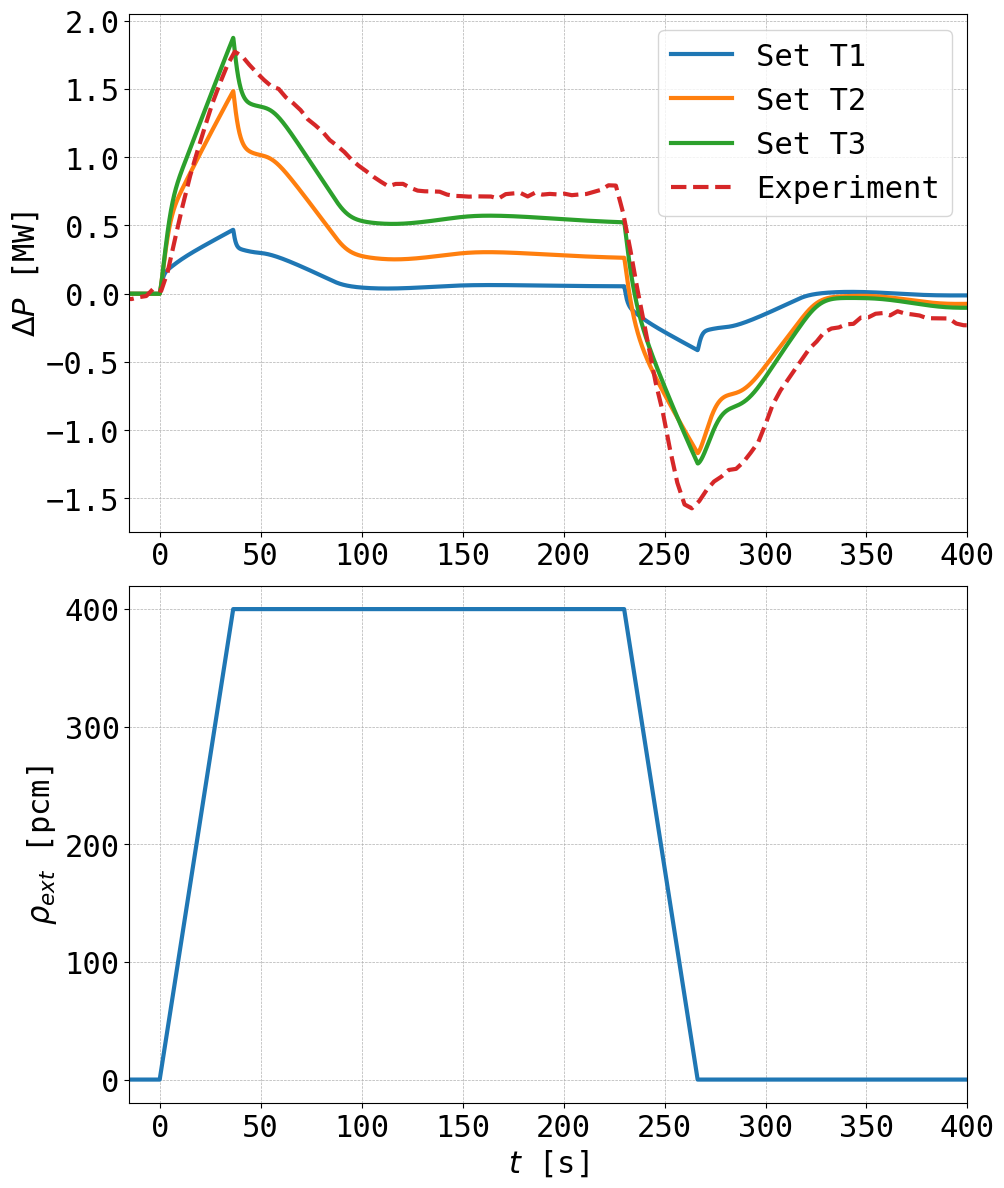

In [5]:
fig, axs = plt.subplots(2,1, figsize = (10,12), sharex = True)

model_base, model_openmc, model_estimation = models
t0, tf = -15.0, 400.0 

adj = (df_power[0][0])*60-T_insert[0]
df_power[0] = [(t*60)-adj for t in df_power[0]]

# adjust to reported power
d = df_power[1][0]-params['P']
df_power[1] = [p-d for p in df_power[1]]

# set up interpolation
spline = CubicSpline(df_power[0], df_power[1]) 
interpolated_values = spline(T[i_insert])

update_axis_style(axs[0], None)
axs[0].plot(T_insert-params['t_ins'],[params['P']*(s-model_base.nodes['n'].y_out[i_insert[0]-1]) for s in model_base.nodes['n'].y_out[i_insert]],label="Set T1",color=colors[0],linewidth=lw)
axs[0].plot(T_insert-params['t_ins'],[params['P']*(s-model_openmc.nodes['n'].y_out[i_insert[0]-1]) for s in model_openmc.nodes['n'].y_out[i_insert]],label="Set T2",color=colors[1],linewidth=lw) 
axs[0].plot(T_insert-params['t_ins'],[params['P']*(s-model_estimation.nodes['n'].y_out[i_insert[0]-1]) for s in model_estimation.nodes['n'].y_out[i_insert]],label="Set T3",color=colors[2],linewidth=lw)
axs[0].plot(df_power[0]-params['t_ins'],df_power[1]-df_power[1][0],label="Experiment",color=colors[3],linestyle='--',linewidth=lw)
axs[0].set_ylabel(r"$\Delta P$ [MW]")
# axs[0].set_xlim([t0,tf])
axs[0].legend(fontsize=tls)

update_axis_style(axs[1], None)
rho_dat = np.array([ARE_dynamic.input_funcs[0](t) for t in T[T>=(params['t_ins']+t0)]])
axs[1].plot(T[T>=(params['t_ins']+t0)]-params['t_ins'], rho_dat*(1e5), label=r'$\rho_{ext}$', linewidth=lw)
axs[1].set_xlim([t0,tf])
axs[1].set_ylabel(r"$\rho_{ext}$ [pcm]")
axs[1].set_xlabel(r"$t$ [s]")

fig.tight_layout()

# fig.savefig('are_insert.png')

Now we examine the temperature correction as applied to the reactivity insertion experiment. This is due to the temperature measurement issues discussed in Appendix K of ORNL-1845. 

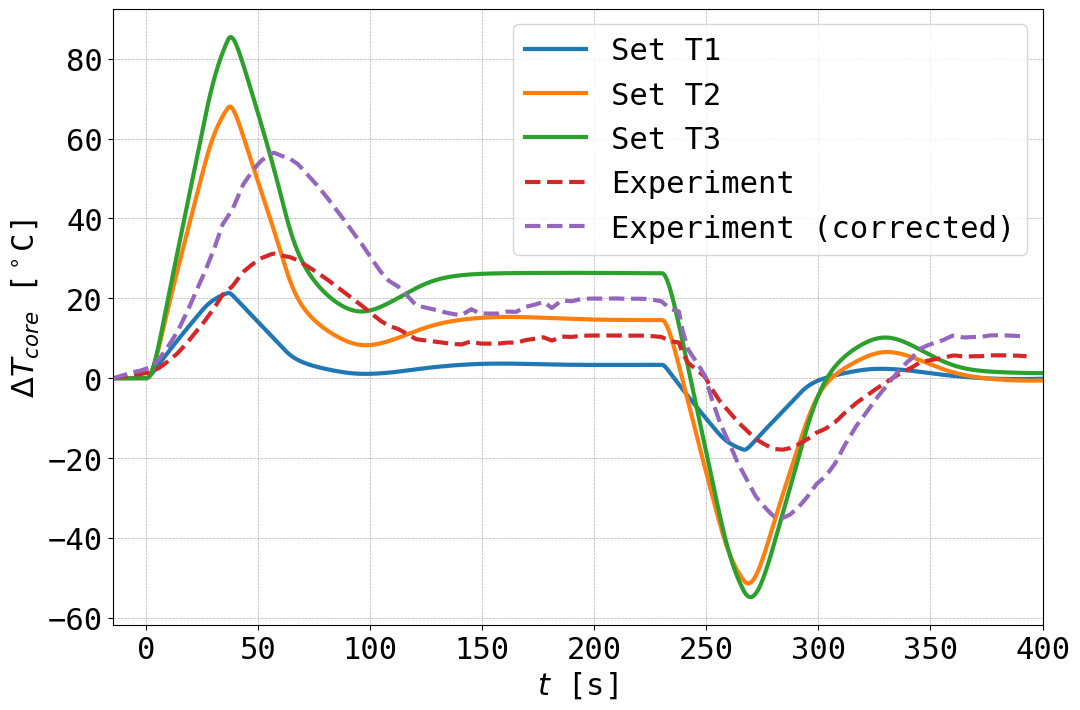

In [7]:
fig, axs = plt.subplots(1,1, figsize = (12,8))

# experimental inlet and outlet data 
df_inlet_interp = interp1d(df_inlet[0]*60-adj,df_inlet[1])
df_outlet_interp = interp1d(df_outlet[0]*60-adj,df_outlet[1])

# applying corrections
interp_range = T_insert<693
corrected_outlet_data = np.polyval(df_outlet_correction_interp,df_outlet_interp(T_insert[interp_range]))
corrected_inlet_data = df_inlet_correction_interp(df_inlet_interp(T_insert[interp_range]))
dT_fuel_exp = (df_outlet_interp(T_insert[interp_range]) - df_inlet_interp(T_insert[interp_range])) - (df_outlet_interp(T_insert[interp_range])[0] - df_inlet_interp(T_insert[interp_range][0]))

# dT_fuel_corrected = corrected_outlet_data - corrected_inlet_data - (corrected_outlet_data[0] - corrected_inlet_data[0])
dT_fuel_corrected = np.polyval(dT_fuel_correction_interp, dT_fuel_exp)
update_axis_style(axs, None)
axs.plot(T_insert-params['t_ins'],(model_base.nodes['c_f2'].y_out[i_insert]-model_base.nodes['hx_fh1_f2'].y_out[i_insert])-(model_base.nodes['c_f2'].y_out[i_insert][0]-model_base.nodes['hx_fh1_f2'].y_out[i_insert][0]),label="Set T1",color=colors[0],linewidth=lw)
axs.plot(T_insert-params['t_ins'],(model_openmc.nodes['c_f2'].y_out[i_insert]-model_openmc.nodes['hx_fh1_f2'].y_out[i_insert])-(model_openmc.nodes['c_f2'].y_out[i_insert][0]-model_openmc.nodes['hx_fh1_f2'].y_out[i_insert][0]),label="Set T2",color=colors[1],linewidth=lw)
axs.plot(T_insert-params['t_ins'],(model_estimation.nodes['c_f2'].y_out[i_insert]-model_estimation.nodes['hx_fh1_f2'].y_out[i_insert])-(model_estimation.nodes['c_f2'].y_out[i_insert][0]-model_estimation.nodes['hx_fh1_f2'].y_out[i_insert][0]),label="Set T3",color=colors[2],linewidth=lw)
axs.plot(T_insert[interp_range]-params['t_ins'], dT_fuel_exp, label = "Experiment", color = colors[3], linewidth = lw, linestyle = '--')
axs.plot(T_insert[interp_range]-params['t_ins'], dT_fuel_corrected, label = "Experiment (corrected)", color = colors[4], linewidth = lw, linestyle = '--')
axs.set_ylabel(r" $\Delta T_{core}$ [$^\circ$C]")
axs.set_xlim([t0,tf])
axs.set_xlabel(r"$t$ [s]")
axs.legend(fontsize=tls)

# fig.savefig('are_temp_correction.png')